In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

In [2]:
dict_gates_one = {"H": lambda args: np.array([[1, 1], [1,-1]], dtype = np.complex64) / np.sqrt(2),
              "X": lambda args: np.array([[0, 1], [1, 0]]),
              "Z": lambda args: np.array([[1, 0], [0, -1]]),
              "RX": lambda theta: np.array([[np.cos(theta / 2), - 1j * np.sin(theta / 2)],[- 1j * np.sin(theta / 2), np.cos(theta / 2)]], dtype = np.complex64),
              "RY": lambda theta: np.array([[np.cos(theta / 2), -np.sin(theta / 2)],[np.sin(theta / 2), np.cos(theta / 2)]], dtype = np.complex64),
              "RZ": lambda theta: np.array([[np.exp(-1j * theta / 2), 0],[0, np.exp(1j * theta / 2)]], dtype = np.complex64)}

dict_gates_two = {"CNOT": lambda args: np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]], dtype = np.complex64),
                  "CP": lambda theta: np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, np.exp(1j * theta)]]),
                  "SWAP": lambda args: np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]),
                  "CZ": lambda args: np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]])}

type_gate = {"H": 0, "X": 0, "Z": 0, "RX": 0, "RY": 0, "RZ": 0, "CNOT": 1, "CP": 1, "SWAP": 1, "CZ": 1}

**Auxiliary Functions**

In [3]:
def fidelity(state_1, state_2):
  state_1 = np.reshape(state_1, np.prod(state_1.shape))
  state_2 = np.reshape(state_2, np.prod(state_2.shape))
  return np.abs(np.vdot(state_1, state_2))**2

def find_length(S, chi):
  for i in range(np.min([chi, len(S)]) - 1, -1, -1):
    if not np.allclose(S[i], 0, atol=1e-07):
      return i + 1

def displace(tensors, q, k):
  if k != None and q > k:
    for i in range(k, q):
      list_shape_0 = tensors[i].shape
      list_shape_1 = tensors[i+1].shape

      common_state = np.tensordot(tensors[i], tensors[i+1], axes = (2, 0))
      common_state = np.reshape(common_state, (list_shape_0[0] * list_shape_0[1], list_shape_1[1] * list_shape_1[2]))
      tensors[i], tensors[i+1] = np.linalg.qr(common_state) # QR factorization
      tensors[i] = np.reshape(tensors[i], (list_shape_0[0], list_shape_0[1], np.prod(tensors[i].shape) // list_shape_0[0] // list_shape_0[1]))
      tensors[i+1] = np.reshape(tensors[i+1], (np.prod(tensors[i+1].shape) // list_shape_1[1] // list_shape_1[2], list_shape_1[1], list_shape_1[2]))


  elif k != None and q < k:
    for i in range(k, q, -1):
      list_shape_0 = tensors[i-1].shape
      list_shape_1 = tensors[i].shape


      common_state = np.tensordot(tensors[i-1], tensors[i], axes = (2, 0))
      common_state = np.transpose(np.reshape(common_state, (list_shape_0[0] * list_shape_0[1], list_shape_1[1] * list_shape_1[2])))
      tensors[i], tensors[i-1] = np.linalg.qr(common_state) # QR factorization
      tensors[i-1] = np.reshape(np.transpose(tensors[i-1]), (list_shape_0[0], list_shape_0[1], np.prod(tensors[i-1].shape) // list_shape_0[0] // list_shape_0[1]))
      tensors[i] = np.reshape(np.transpose(tensors[i]), (np.prod(tensors[i].shape) // list_shape_1[1] // list_shape_1[2], list_shape_1[1], list_shape_1[2]))

In [4]:
class MPSState:

  def __init__(self, n_qubit, chi_val):
    self.n = n_qubit
    self.chi = chi_val
    self.tensors = []
    self.k = None # index of the N
    for i in range(n_qubit): # construction of the representation
      if i == 0 and i == n_qubit - 1:
        self.tensors.append(np.zeros((1, 2, 1), dtype = np.complex64))
      elif i == 0:
        self.tensors.append(np.zeros((1, 2, self.chi), dtype = np.complex64))
      elif i == n_qubit - 1:
        self.tensors.append(np.zeros((self.chi, 2, 1), dtype = np.complex64))
      else:
        self.tensors.append(np.zeros((self.chi, 2, self.chi), dtype = np.complex64))
      self.tensors[i][0, 0, 0] = 1 # initialization

  def apply_1(self, gate, args, qubit):
    self.tensors[qubit] = np.tensordot(dict_gates_one[gate](args), self.tensors[qubit], axes = (1,1))
    self.tensors[qubit] = np.moveaxis(self.tensors[qubit], (0, 1), (1, 0))


  def apply_2(self, gate, args, qubit, flag): # act on (q, q + flag)
    assert flag == 1 or flag == -1, "Wrong value of flag"
    if flag == 1:
      displace(self.tensors, qubit, self.k) # Change where is k
    elif flag == -1:
      displace(self.tensors, qubit - 1, self.k) # Change where is k
    # a
    if flag == 1:
      T = np.tensordot(self.tensors[qubit], self.tensors[qubit + 1], axes = (2, 0))
    if flag == -1:
      T = np.tensordot(self.tensors[qubit - 1], self.tensors[qubit], axes = (2, 0))
      T = np.moveaxis(T, (1,2), (2,1))
    size_0, size_1 = T.shape[0], T.shape[-1] # to take care of the cases when  one of the qubits is on the edge
    T = np.reshape(T, (size_0, 4, size_1))

    # b
    T = np.tensordot(dict_gates_two[gate](args), T, axes = (1,1))
    T = np.moveaxis(T, (0,1),(1,0))
    if flag == -1: # reverse the axis inversion
      T = np.reshape(T, (size_0, 2, 2, size_1))
      T = np.moveaxis(T, (1,2), (2,1))

    # c
    T = np.reshape(T, (size_0, 2,  2, size_1)) # split before reshaping
    T = np.reshape(T, (2 * size_0, 2 * size_1))
    U, S, Vh = np.linalg.svd(T, full_matrices=False)

    # d: truncation
    length = find_length(S,self.chi)
    S = S[:length] / np.linalg.norm(S[:length])
    U = np.reshape(U[:, :length] @ np.diag(S) , (size_0, 2, length))
    Vh = np.reshape(Vh[:length, :], (length, 2, size_1))
    # e
    if flag == 1:
      self.tensors[qubit] = U
      self.tensors[qubit + 1] = Vh
      self.k = qubit
    if flag == -1:
      self.tensors[qubit - 1] = U
      self.tensors[qubit] = Vh
      self.k = qubit-1

  def expectation(self, operator, qubit):
    displace(self.tensors, qubit, self.k)
    apply_operator = np.tensordot(operator, self.tensors[qubit], axes = (1, 1))
    apply_operator = np.moveaxis(apply_operator, (0, 1), (1, 0))
    apply_operator = np.reshape(apply_operator, np.prod(apply_operator.shape))
    state_value = np.reshape(self.tensors[qubit], np.prod(self.tensors[qubit].shape))
    return np.vdot(state_value, apply_operator)

In [5]:
class QuantumCircuit:

  def __init__(self, n_qubit, list_gates = []): # allows to define a circuit by some initial list of gates

    self.n = n_qubit
    self.gates = list_gates.copy() # copy to avoid double access to the same memory

  def to_vec(self, state):
    a = state.tensors[0] # compute the coefficients on the tensor basis for analyzing them
    for k in range(self.n - 1):
      a = np.tensordot(a, state.tensors[k + 1], axes = (-1, 0))
    a = np.reshape(a, [2]*self.n)
    return a

  def simulate(self, chi, convert = True, operator = None, q_measure = None):
    state = MPSState(self.n, chi)
    time_stamp = time()


    for info in self.gates:

      if type_gate[info[0]] == 0:
        gate, args, qubit = info
        state.apply_1(gate, args, qubit)

      elif type_gate[info[0]] == 1:
        gate, args, qubit, flag = info

        if np.abs(flag) == 1:
          state.apply_2(gate, args, qubit, flag)

        else:
          for k in range(0, flag - np.sign(flag), np.sign(flag)): # SWAP wall
            state.apply_2("SWAP", None, qubit + k, np.sign(flag))

          state.apply_2(gate, args, qubit + flag - np.sign(flag), np.sign(flag))

          for k in range(flag - 2 * np.sign(flag), -np.sign(flag), -np.sign(flag)): # Inverse SWAP wall
            state.apply_2("SWAP", None, qubit + k, np.sign(flag))


    if convert and operator == None:
      a = self.to_vec(state)
      return a, time() - time_stamp
    elif not convert and np.all(operator != None) and q_measure != None:
      return state.expectation(operator, q_measure), time() - time_stamp
    else:
      return time() - time_stamp

  def random_circuit(self, depth):
    for i in range(depth):
      for q in range(self.n):
        its = np.random.choice([0, 1, 2])
        if its == 0:
          self.gates.append(("RX", np.random.uniform(low = 0, high = 2 * np.pi), q))
        elif its == 1:
          self.gates.append(("RY", np.random.uniform(low = 0, high = 2 * np.pi), q))
        elif its == 2:
          self.gates.append(("RZ", np.random.uniform(low = 0, high = 2 * np.pi), q))

        if q < self.n - 1 and (q - i) % 2 == 0:
          self.gates.append(("CNOT", None, q, 1))

  def H_wall(self):
    for k in range(self.n):
      self.gates.append(("H", None, k))
"""
  def QFT(self):

    def step_QFT(n_qubit):
      self.gates.append(("H", None, n_qubit))
      if n_qubit >= 1:
        for k in range(1, n_qubit):
          self.gates.append(("CP", np.pi / 2**k, [n_qubit, n_qubit - k]))
        step_QFT(n_qubit - 1) # recursive construction

    #step_QFT(self.n - 1)
"""

'\n  def QFT(self):\n\n    def step_QFT(n_qubit):\n      self.gates.append(("H", None, n_qubit))\n      if n_qubit >= 1:\n        for k in range(1, n_qubit):\n          self.gates.append(("CP", np.pi / 2**k, [n_qubit, n_qubit - k]))\n        step_QFT(n_qubit - 1) # recursive construction\n\n    #step_QFT(self.n - 1)\n'

**Hadamard gate**

In [6]:
n_qubit = 1
chi = 1
list_gates = [("H", None, 0)]

circuit = QuantumCircuit(n_qubit, list_gates)

state, duration = circuit.simulate(chi)

In [7]:
state

array([0.70710677+0.j, 0.70710677+0.j], dtype=complex64)

In [8]:
print("Norm squared of the final state:" , fidelity(state, state))

Norm squared of the final state: 0.999999880790714


In [9]:
print("Duration:", duration)

Duration: 0.0017616748809814453


**Hadamard wall (with a test for the phase)**

In [10]:
n_qubit = 2
chi = 2
circuit = QuantumCircuit(n_qubit, [("X", None, 1)])
circuit.H_wall()
state, duration = circuit.simulate(chi)

In [11]:
state

array([[ 0.49999998+0.j, -0.49999998+0.j],
       [ 0.49999998+0.j, -0.49999998+0.j]])

In [12]:
print("Norm squared of the final state:" , fidelity(state, state))

Norm squared of the final state: 0.99999986308584


In [13]:
print("Duration:", duration)

Duration: 0.025120973587036133


**Rotation Gates**

In [14]:
n_qubit = 1
chi = 1
list_gates = [("RX", 2.97263637828271828287665658391919, 0)]

circuit = QuantumCircuit(n_qubit, list_gates)

state, duration = circuit.simulate(chi)

In [15]:
state

array([0.08437769+0.j        , 0.        -0.99643385j], dtype=complex64)

In [16]:
print("Norm squared of the final state:" , fidelity(state, state))

Norm squared of the final state: 1.0


In [17]:
print("Duration:", duration)

Duration: 0.00025534629821777344


**CNOT**

In [18]:
n_qubit = 3
chi = 2
list_gates = [("CNOT", None, 0, 1)] + [("CNOT", None, 1, 1)] + [("CNOT", None, 0, 1)]
circuit = QuantumCircuit(n_qubit, list_gates)
state, duration = circuit.simulate(chi)

In [19]:
print("Norm squared of the final state:" , fidelity(state, state))

Norm squared of the final state: 1.0


In [20]:
state

array([[[1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]]], dtype=complex64)

**CNOT + Hadamard**

In [21]:
n_qubit = 3
chi = 2
circuit = QuantumCircuit(n_qubit)
circuit.gates.append(("RX", 2.9726363782827, 0))
circuit.gates.append(("CNOT", None, 0, 1))
circuit.gates.append(("CNOT", None, 1, 1))
circuit.gates.append(("CNOT", None, 0, 1))
state, duration = circuit.simulate(chi)

**100 qubits**

We cannot convert the matrix product state into a tensor state for 100 qubits. However, the computations can be done quite rapidly.

In [22]:
n_qubit = 100
chi = 100
circuit = QuantumCircuit(n_qubit)
circuit.H_wall()
duration = circuit.simulate(chi, False)

In [23]:
print("Duration:", duration)

Duration: 0.0832817554473877


**Bell State Circuit**

In [24]:
n_qubit = 3
chi = 2
list_gates = [("H", None, 0), ("CNOT", None, 0, 1), ("CNOT", None, 1, 1)]
circuit = QuantumCircuit(n_qubit, list_gates)
state, duration = circuit.simulate(chi)

In [25]:
print("Duration:", duration)

Duration: 0.007483720779418945


In [26]:
print("Norm squared of the final state:" , fidelity(state, state))

Norm squared of the final state: 1.0000002384185933


**Bell State with Inversed Gate**

In [27]:
n_qubit = 2
chi = 2
list_gates = [("H", None, 1), ("CNOT", None, 1, -1)]
circuit = QuantumCircuit(n_qubit, list_gates)
state, duration = circuit.simulate(chi)

In [28]:
print("Duration:", duration)

Duration: 0.000997781753540039


In [29]:
state

array([[0.7071068+0.j, 0.       +0.j],
       [0.       +0.j, 0.7071068+0.j]], dtype=complex64)

In [30]:
print("Norm squared of the final state:" ,fidelity(state, state))

Norm squared of the final state: 1.0000002384185933


**Random Circuit simulator**

In [31]:
n_ = 10
depth = 1000
circuit_ = QuantumCircuit(n_)
circuit_.random_circuit(depth)

In [32]:
chi = 100
state_100, duration = circuit_.simulate(chi)

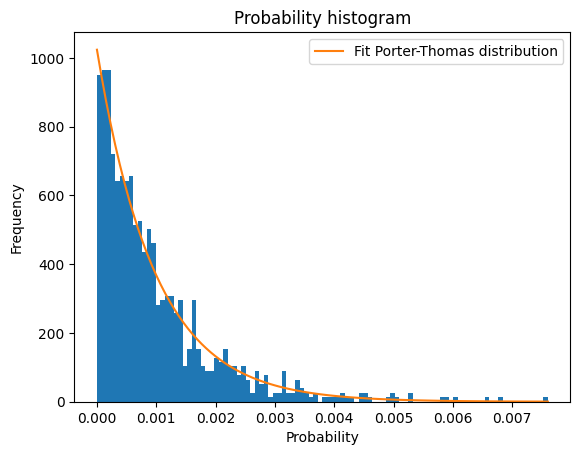

In [33]:
probs_res = np.abs(state_100) ** 2
probs_res = probs_res.flatten()
X = np.linspace(0, np.max(probs_res), 100)
plt.hist(probs_res.flatten(), bins = 100, density = True)
plt.plot(X, 2**n_* np.exp(-2**n_ * X), label = "Fit Porter-Thomas distribution")

plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.title("Probability histogram")
plt.legend()

In [34]:
chi = 10
state_10, duration = circuit_.simulate(chi)

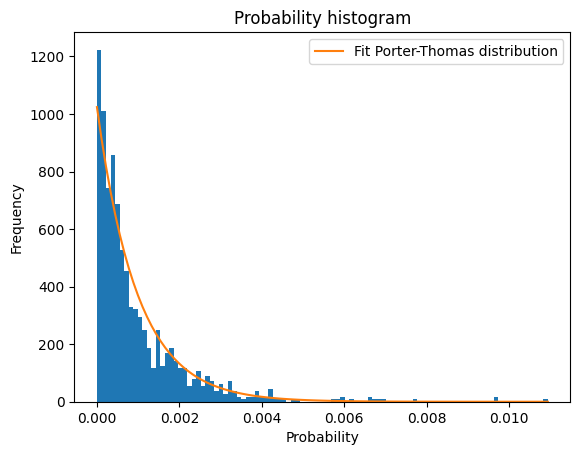

In [35]:
probs_res = np.abs(state_10) ** 2
probs_res = probs_res.flatten()
X = np.linspace(0, np.max(probs_res), 100)
plt.hist(probs_res.flatten(), bins = 100, density = True)
plt.plot(X, 2**n_* np.exp(-2**n_ * X), label = "Fit Porter-Thomas distribution")

plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.title("Probability histogram")
plt.legend()

In [36]:
norm2_100 = fidelity(state_100, state_100)
norm2_10 = fidelity(state_10, state_10)
print("Norm squared of the final state for 100:" , norm2_100)
print("Norm squared of the final state for 10:" , norm2_10)
print("Fidelity between the two states:" , fidelity(state_10, state_100) / np.sqrt(norm2_100 * norm2_10))

Norm squared of the final state for 100: 1.0000002384185933
Norm squared of the final state for 10: 1.0
Fidelity between the two states: 0.00019056229454256107


**CNOT(0, 2)**

In [37]:
n_qubit = 3
chi = 2
list_gates = [("X", None, 0)] + [("SWAP", None, 0, 1)] + [("CNOT", None, 1, 1)] + [("SWAP", None, 0, 1)]
circuit = QuantumCircuit(n_qubit, list_gates)
state, duration = circuit.simulate(chi)

In [38]:
print("Duration:", duration)

Duration: 0.0057065486907958984


In [39]:
state

array([[[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]],

       [[0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j]]])

In [40]:
n_qubit = 3
chi = 2
list_gates = [("X", None, 0)] + [("CNOT", None, 0, 2)]
circuit = QuantumCircuit(n_qubit, list_gates)
state, duration = circuit.simulate(chi)

In [41]:
print("Duration:", duration)

Duration: 0.0057582855224609375


In [42]:
state

array([[[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]],

       [[0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j]]])

**CNOT(2, 0)**

In [43]:
n_qubit = 3
chi = 2
list_gates = [("X", None, 2)] + [("SWAP", None, 1, 1)] + [("CNOT", None, 1, -1)] + [("SWAP", None, 1, 1)]
circuit = QuantumCircuit(n_qubit, list_gates)
state, duration = circuit.simulate(chi)

In [44]:
print("Duration:", duration)

Duration: 0.010974645614624023


In [45]:
state

array([[[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]],

       [[0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j]]])

In [46]:
n_qubit = 3
chi = 2
list_gates = [("X", None, 2)] + [("CNOT", None, 2, -2)]
circuit = QuantumCircuit(n_qubit, list_gates)
state, duration = circuit.simulate(chi)

In [47]:
print("Duration:", duration)

Duration: 0.009759187698364258


In [48]:
state

array([[[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]],

       [[0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j]]])

**Expectation of 1-Local Operators**

In [49]:
op_1 = np.array([[1, 0], [0, 0]]) # probability to get 0
n_qubit = 1
chi = 2
circuit = QuantumCircuit(n_qubit, [("H", None, 0)])
exp, duration = circuit.simulate(chi, convert = False, operator = op_1, q_measure = 0)
print("Computed expectation value", exp)

Computed expectation value (0.4999999828857291+0j)


In [50]:
op_2 = np.array([[3, 1j], [-1j, -1]])
n_qubit = 1
chi = 2
circuit = QuantumCircuit(n_qubit, [("H", None, 0)])
exp, duration = circuit.simulate(chi, convert = False, operator = op_2, q_measure = 0)
print("Computed expectation value", exp)
print("Theoretical expectation value", 0.5 * np.array([1, 1]) @ np.array([[3, 1j], [-1j, -1]]) @ np.array([[1], [1]]))

Computed expectation value (0.9999999657714582+0j)
Theoretical expectation value [1.+0.j]


In [51]:
op_1 = np.array([[1, 0], [0, 0]]) # probability to get 0
n_qubit = 2
chi = 2
circuit = QuantumCircuit(n_qubit, [("H", None, 0), ("CNOT", None, 0, 1)])
exp, duration = circuit.simulate(chi, convert = False, operator = op_1, q_measure = 0)
print("Computed expectation value", exp)

Computed expectation value (0.5000000671794282+0j)
